In [51]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [52]:
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np

In [53]:
dl = DataLib("SignalData")
country_codes = dl.pull('LongRates').columns

# Notes

1) **Opportunity Cost**
    - International Opp Cost: Curve Height
        * what other countries can I invest in?
        * low curve height -> more likely to invest in other countries -> prices go down
        * positive relationship
        * important to compare relative to other countries
    - Domestic Opp Cost: Economic Growth (Change in GDP)
        * more places to productively put your money to use when the economy is booming
        * positive growth -> lack of demand for bonds -> prices go down
        * inverse relationship
        * important to compare relative to the past
        
2) **Inflation Expectations**
    - high inflation expectations -> less of a demand for bonds -> prices go down
    - CPI/SA
        * compare relative to the past
        * 5 year rolling average?
    - Using change in money supply additionally?
        * change in M2 or M3
        * what about credit?
    - Change in GDP
        * high economic growth: expect inflation to go up
    
3) **General Risk Sentiment**
    - Bond Risk Premium? Unsure
    
    
**Leaning towards curve height, change in GDP, and CPI/SA (possibly with monetary base as well)**

# Profit and Loss Curve

In [54]:
def pnl_curve(signal):
    bond_return_index = dl.pull('BondRetIdx/LocalFX')
    bond_daily_returns = bond_return_index.pct_change()
    bond_monthly_returns = bond_daily_returns.resample('M')
    lagged_returns = bond_daily_returns.shift(-1)

    signal = signal.resample('B').ffill()
    signal_returns = lagged_returns * signal
    total_signal_returns = signal_returns.sum(axis=1)
    cum_signal_returns = (1+total_signal_returns).cumprod()
    signal_pct = (cum_signal_returns-1)*100

    cum_signal_returns.plot(color='magenta', label = 'Signal Returns')
    plt.ylabel('Cumulative Returns (% Points)')
    plt.title('Cumulative Profit and Loss Curve')
    plt.legend()


# Plot Variables vs. Bond Returns for Each Country

In [55]:
# do I want to compare to current bond returns or future bond returns?

def plot_vs_returns(df, var_window=1):
    bond_return_index = dl.pull('BondRetIdx/LocalFX')
    bond_daily_returns = bond_return_index.pct_change()
    bond_monthly_returns = bond_daily_returns.resample('M').mean()
    bond_monthly_returns = bond_monthly_returns.shift(-1)
    
    for country in country_codes:
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.plot(df[country].to_timestamp().rolling(var_window).mean(), color='blue', 
                 label = 'variable of interest')
        ax2.plot(bond_monthly_returns[country].to_timestamp()
         .rolling(60).mean(),color='magenta', label = 'bond returns')
        plt.title(country + ' Variable of Interest vs. Bond Returns')

# Curve Height

When using curve height as an indicator, it's most important to judge the different curve heights relative to other countries in a given year, since curve height is representative of international opportunity cost and will drive flows between different countries. Secondly, curve height should be measured based on its value relative to other countries, rather than its change over time. Our best indicator will tell us where a country's curve height lies relative to other countries, rather than whether it is increasing or decreasing, because its relative value is what will drive investors to buy or sell in different countries, causing prices to either rise or fall in the future.

To calculate our indicator, first, we'll calculate curve height as an average of long and short rates.

In [28]:
long_rates = dl.pull('LongRates')
short_rates = dl.pull('ShortRates')

curve_height = (long_rates+short_rates)/2
curve_height.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,0.4490,-0.5615,0.5040,0.2885,-0.2510,0.9795,-0.0635,-0.4605,0.2145,0.4345
2020-05,0.5590,-0.6725,0.4275,0.3120,-0.3555,1.1510,-0.0920,-0.5950,0.1415,0.4210
2020-06,0.5865,-0.5230,0.4090,0.0900,-0.2650,0.9060,-0.0780,-0.5710,0.1155,0.4100
2020-07,0.6020,-0.5300,0.4065,0.0090,-0.3270,0.7250,-0.0450,-0.5235,0.0750,0.4230
2020-08,0.5535,-0.6240,0.3655,-0.0215,-0.4165,0.5350,-0.0610,-0.6650,0.0185,0.3235


As discussed above, relative curve heights are important when determining opportunity cost between different countries. To relativize the curve heights in each year, I calculated a simple moving global average that incorporates values from the last five years and subtracted it from each value, to show how each country's curve height compared to the global average (in absolute terms). I then standardized within countries so that the mean and standard deviation within each country was 0 and 1, respectively.

In [92]:
global_avgs = curve_height.mean(axis=1)
CH_sma_5Y = global_avgs.rolling(60).mean()

relative_CH = curve_height.sub(CH_sma_5Y,axis=0)
standardized_CH = ((relative_CH.rolling
                    (60).mean()- relative_CH)/relative_CH.rolling(60).std())
standardized_CH.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,2.315560,-0.300835,0.652760,-0.830532,-0.592027,-0.584650,-1.532534,-1.505126,0.616738,1.240492
2020-05,1.969010,0.132208,0.758189,-0.957219,-0.213659,-0.836722,-1.424099,-1.118820,0.819116,1.255135
2020-06,1.817181,-0.510850,0.785261,0.009061,-0.582951,-0.452496,-1.466988,-1.189550,0.867859,1.260142
2020-07,1.684364,-0.524885,0.786619,0.298325,-0.384251,-0.179163,-1.577362,-1.328781,0.933684,1.222993
2020-08,1.694684,-0.170142,0.851853,0.382546,-0.068629,0.118027,-1.513523,-0.926700,1.058074,1.333836


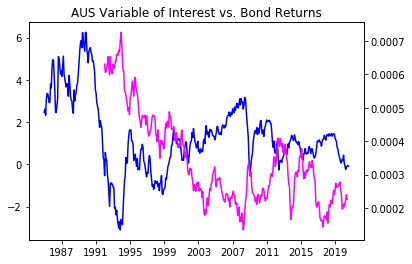

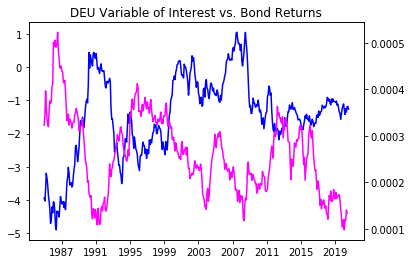

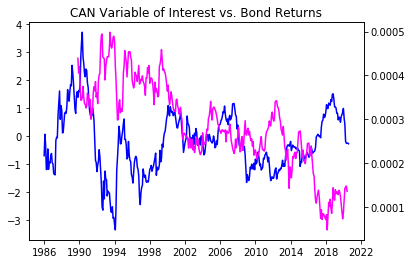

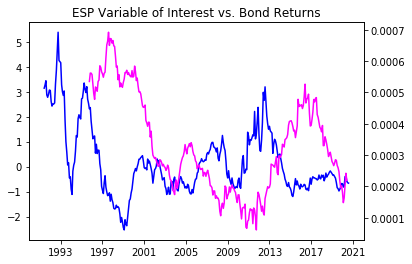

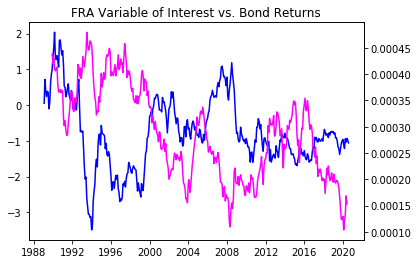

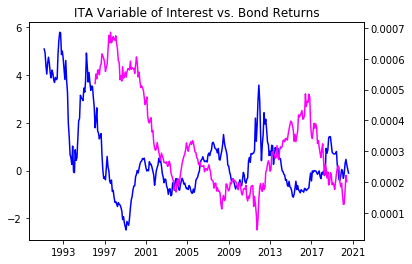

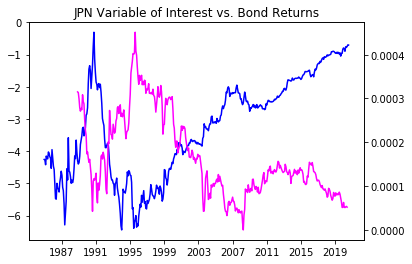

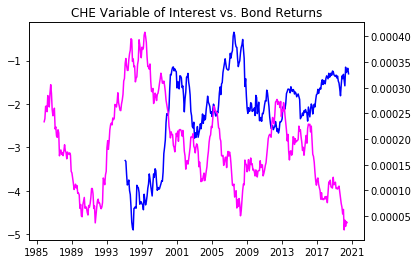

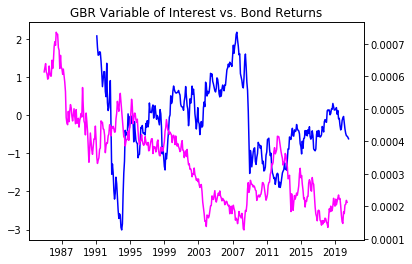

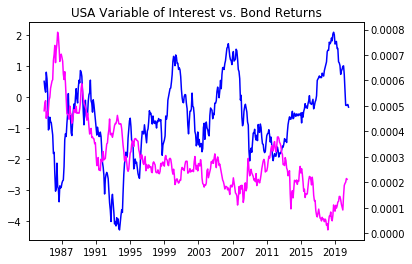

In [93]:
# these curves don't look as I expected, need to think about if the relationship is inverse
plot_vs_returns(relative_CH)

In [90]:
CH_signals = standardized_CH.clip(-1,1)
CH_signals.tail()

# This is a very simple linear signal, going to think about thresholding and alter this

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2020-04,-1.0,0.300835,-0.652760,0.830532,0.592027,0.584650,1.0,1.0000,-0.616738,-1.0
2020-05,-1.0,-0.132208,-0.758189,0.957219,0.213659,0.836722,1.0,1.0000,-0.819116,-1.0
2020-06,-1.0,0.510850,-0.785261,-0.009061,0.582951,0.452496,1.0,1.0000,-0.867859,-1.0
2020-07,-1.0,0.524885,-0.786619,-0.298325,0.384251,0.179163,1.0,1.0000,-0.933684,-1.0
2020-08,-1.0,0.170142,-0.851853,-0.382546,0.068629,-0.118027,1.0,0.9267,-1.000000,-1.0


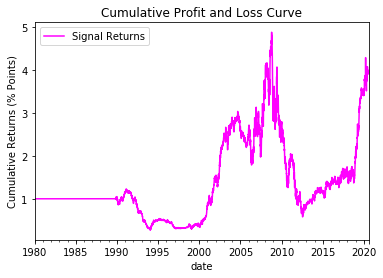

# Change in GDP

In [56]:
RGDP = dl.pull("GDP/Real")
RGDP_QOQ = RGDP.pct_change()
RGDP_QOQ.tail()

country,AUS,DEU,CAN,ESP,FRA,ITA,JPN,CHE,GBR,USA
date,,,,,,,,,,
2019Q3,0.005546,0.003093,0.002792,0.004047,0.001579,0.000052,0.000038,0.004400,0.005116,0.006369
2019Q4,0.005209,-0.000187,0.001397,0.004104,-0.001856,-0.002286,-0.018566,0.003379,-0.000001,0.005862
2020Q1,-0.003060,-0.020186,-0.021089,-0.052090,-0.059396,-0.053805,-0.005586,-0.026071,-0.021872,-0.012627
2020Q2,0.000000,-0.100915,0.000000,-0.184840,-0.138151,-0.123579,0.000000,0.000000,0.000000,-0.094947
2020Q3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [70]:
global_avg_5Y = RGDP_QOQ.rolling(20).mean().mean(axis=1)

# how is it doing relative to the global avg over the past 5 years?
relative_growth = (RGDP_QOQ.sub(global_avg_5Y, axis=0))

# how does that relative performance compare to the country's relative performance
# over the past 10 years?
standardized_rel_growth = (relative_growth.rolling(40).
                           mean()-relative_growth)/relative_growth.rolling(40).std()



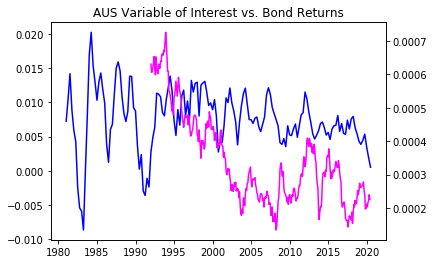

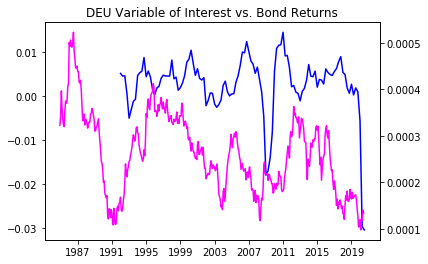

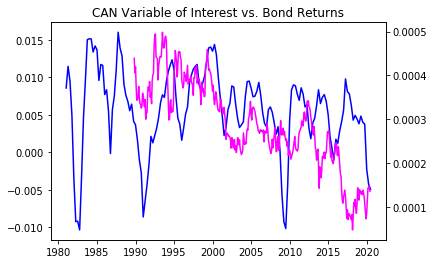

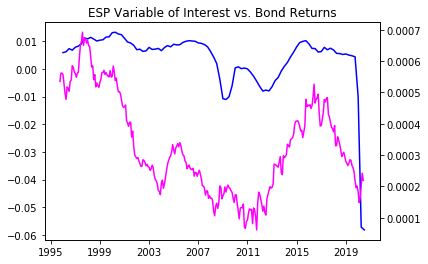

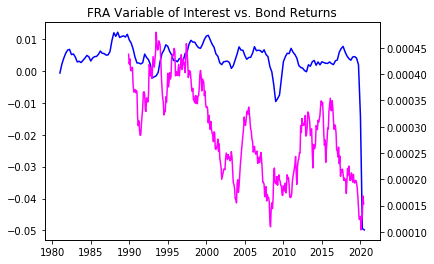

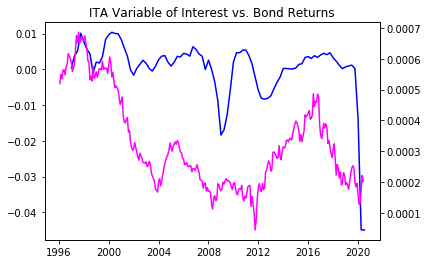

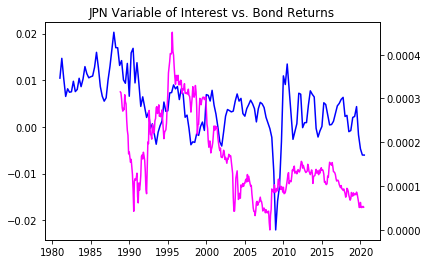

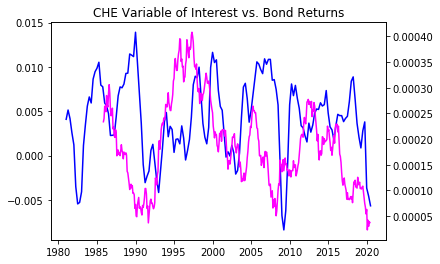

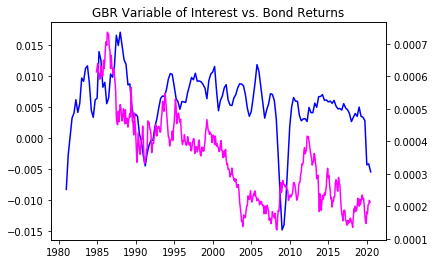

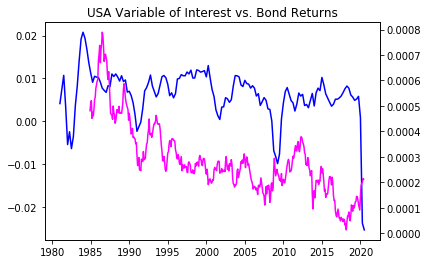

In [72]:
# again, need to look at these graphs
plot_vs_returns(RGDP_QOQ, 4)

In [81]:
GDP_signals = standardized_rel_growth.clip(-1,1)

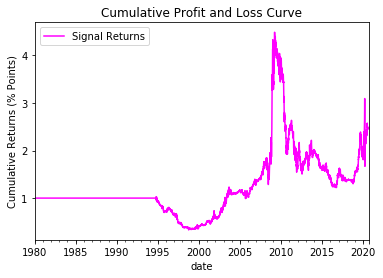

In [82]:
pnl_curve(GDP_signals)

# Consumer Price Index (need to work on this one more)

In [83]:
CPI = dl.pull('CoreCPI/SA')
CPI_change = CPI.pct_change()

# how does inflation compare historically within countries?
standardized_inf = CPI_change - CPI_change.mean()/CPI_change.std()

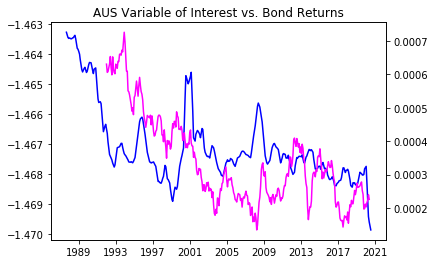

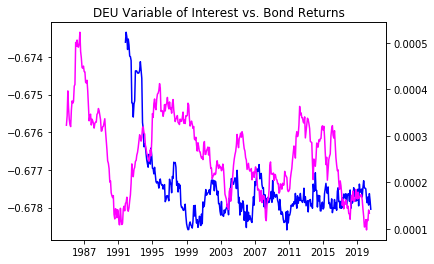

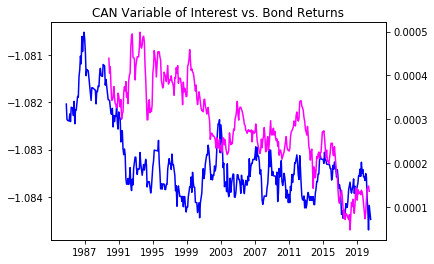

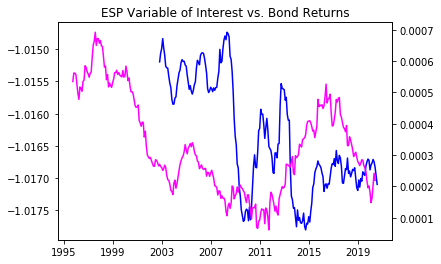

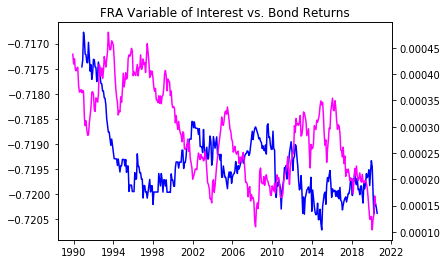

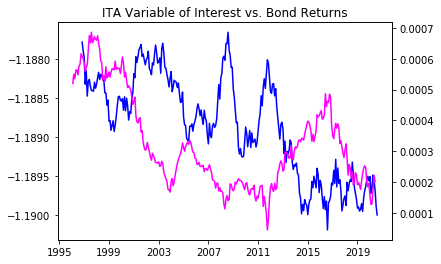

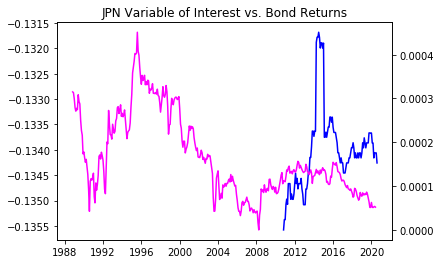

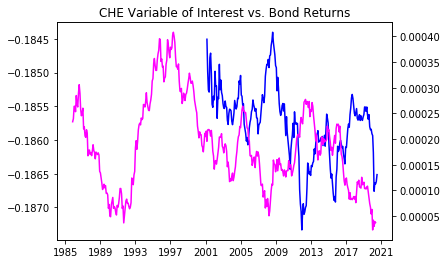

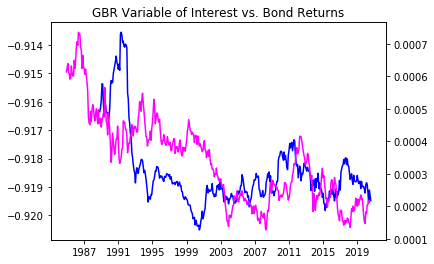

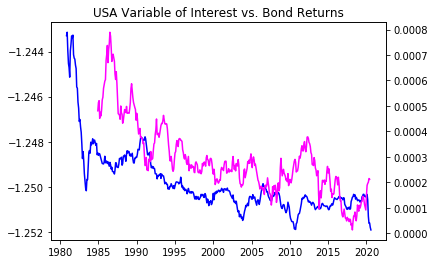

In [84]:
plot_vs_returns(standardized_inf, 10)

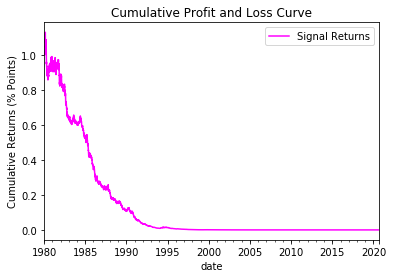

In [85]:
# need to look at this
pnl_curve(generate_signals(standardized_inf))

# Bond Premium

In [37]:
bond_premium = long_rates - short_rates
BP_change = bond_premium.pct_change()

standardized_BP = ((BP_change - BP_change.mean())/BP_change.std())